# PyTorch Food101 Claassification with simple CNN.

**What's this about?**
        
    This notebook is my sum-up project in learning basic CNNs. I chose working on Food101 dataset to challenge myself working with
    huge amount of classes. I will try to recreate VGG-alike architecture with pure `PyTorch` and optimize it to fit Food101 data.

**My setup**

    CPU: AMD Ryzen 7
    GPU: NVidia RTX 5070
    RAM: 32GB
    System: Kubuntu

## Understanding Food101:
As i mentioned before, Food101 is a good challenge for me, it has 101 different classes, only 750 images per train class. Unfortunatelly, Food101 is not perfect and has its issues (we check it later). Although i coud use `torchvision.datasets` to get Food101, i decided to download it as zip archieve and have it locally as image directories. Doing this will help to build custom `Dataset`. For better performance I will take 10 random classes from 101, to practice on and later change amount of classes back to normal.

Kaggle link to same dataset - https://www.kaggle.com/datasets/dansbecker/food-101


## Table of Contents:





## Requirements

* torch
* torchvision
* numpy
* tqdm
* torchmetrics
* pandas
* matplotlib

In [5]:
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install numpy
!pip3 install torchmetrics
!pip3 install tqdm
!pip3 install pandas

## Importing libraries and setup device agnostic code

In [6]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(42)

# if GPU is available, then use it
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")
print(torch.__version__)
print(torchvision.__version__)

Running on: cuda
2.10.0+cu128
0.25.0+cu128


## Get familiar with the data

After food101 is downloaded, unpack it to `./data/`. The structure should be something like this:

    .
    ├── data 
    │   └── food-101  <- unpacked archieve
    │       ├── images
    │       ├── license_agreement.txt
    │       ├── meta
    │       └── README.txt
    ├── food101-problem.ipynb
    └── Pipfile

`./data/food-101/meta/` there are some `.txt` files. Those files contain information of which images are for training, and which are for testing.

Format of those files are:
    
    apple_pie/1005649

Where 'apple_pie' is a directory (class of food) and '1005649' name of the image


## Splitting our data.
Now using information we got, let's build `split_data()` function, which:

* Creates a new path for splitted data
* Inside that path, creates train and test directories
* Parse `./data/food-101/images/` using `./data/food-101/meta/train.txt` and `./data/food-101/meta/test.txt`


**NOTE**: `split_function()` creates copies of all images, so bascially it doubles data (5.2 GB -> 10.4 GB)

In [7]:
import os
import shutil
from pathlib import Path

# Set the root directory path
root_dir = Path("./data/food-101/")

# Unsorted images path
images_dir = root_dir / "images"

# Create a new path for splitted data
splitted_dir = Path("./data/splitted_data/")
splitted_dir.mkdir(parents=True, exist_ok=True)

# Create 2 directories for train and test data
train_dir = splitted_dir / "train"
train_dir.mkdir(parents=True, exist_ok=True)

test_dir = splitted_dir / "test"
test_dir.mkdir(parents=True, exist_ok=True)

# txt files 
train_txt = root_dir / "meta/train.txt"
test_txt = root_dir / "meta/test.txt"

train_dir, test_dir, train_txt, test_txt

(PosixPath('data/splitted_data/train'),
 PosixPath('data/splitted_data/test'),
 PosixPath('data/food-101/meta/train.txt'),
 PosixPath('data/food-101/meta/test.txt'))

In [8]:
# What's inside txt files?
with open(train_txt) as f:
    print(f.readline())

apple_pie/1005649



In [9]:
def split_data(images_dir, target_dir, txt_file):
    with open(txt_file) as f:
        for line in f:
            line_sample = line.strip() + ".jpg" # add '.jpg' to our image name
            class_name, img_name = line_sample.split("/") # split image path into direcotry name (class) and image

            class_dir = target_dir / class_name # Create directory for a class inside target dir (train our test)
            class_dir.mkdir(parents=True, exist_ok=True)

            src_img = images_dir / class_name / img_name # Get current image as a path
            target_img = class_dir / img_name # Where we want to copy our image

            # if image wasn't copied before, then do it
            if not target_img.exists():
                shutil.copy(src_img, class_dir)

In [10]:
# Copy train images first
split_data(
    images_dir=images_dir, # directory with all images
    target_dir=train_dir, # Where to copy selected images
    txt_file=train_txt # which images are for training
)

Using Linux terminal command `tree` we can see our file structure for train_data

    .
    ├── test
    └── train  [101 entries exceeds filelimit, not opening dir]
    
    3 directories, 0 files

We can inspect 101 directories (classes) inside train directory. Function works fine

In [11]:
split_data(
    images_dir=images_dir, # Path to all images
    target_dir=test_dir, # Where to copy selected images
    txt_file=test_txt # which images go for testing
)

    .
    ├── test  [101 entries exceeds filelimit, not opening dir]
    └── train  [101 entries exceeds filelimit, not opening dir]
    
    3 directories, 0 files

Excellent, now we have our data splitted.

In [12]:
print(f"Total amount images in train dir: {sum(1 for x in train_dir.glob("*/*.jpg"))}")
print(f"Total amount images in train dir: {sum(1 for x in test_dir.glob("*/*.jpg"))}")

Total amount images in train dir: 75750
Total amount images in train dir: 25250


Based on information above, we can say that each training class has 750 images, and each testing class has 250 images.

Assuming that we have 101 class, 750 images for training doesn't look good enough for simple CNN Architecture. Although it's true, I will try to get the best results.

## Creating Dataset with only 10 classes

Splitting our Data of 101 class into 10 classes can be a useful practice. It works for this project, beacuse each class has the same amount of images.

To create a custom Dataset we will:

* Create a simple Dataset with 101 classes (without any transformer)
* Select 10 random classes from it
* Create indices for train and test datasets
* Create Subset, using `torch.utils.data.Subset`
* Build custom `Dataset` class


*What are indices?*:
    
    Each class is an index, for example 0 index can be pizza class. We have 750 images and all them will have index 0, which means there are 750 images
    of pizza. Indices mapping those indexes to be in range 0-9, because we want to 'squeeze' our 101 class.

*Why create custom `Dataset` class?*

    If we use inbuilt `ImageFolder`, it will scan the whole directory, so we can't have n number of classes.

In [9]:
from torchvision import datasets

# We do not apply any transforms, because we will do it on our custom dataset.
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=None,
    target_transform=None
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=None,
    target_transform=None
)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 75750
     Root location: data/splitted_data/train,
 Dataset ImageFolder
     Number of datapoints: 25250
     Root location: data/splitted_data/test)

In [10]:
# Dataset has methods .classes and .class_to_idx
# We will recreate them as well in our custom dataset

train_dataset.classes[:10], len(train_dataset.classes)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)

### Prepare data before creating custom dataset class

In [11]:
import random

random.seed(42)

# Choose 10 random classes
selected_classes = random.sample(range(101), 10)
selected_classes

[81, 14, 3, 94, 35, 31, 28, 17, 13, 86]

In [12]:
# Creating indices

# if label is in selected_classes, then add its index to indices
train_indices = [i for i, l in enumerate(train_dataset.targets) if l in selected_classes]
test_indices = [i for i, l in enumerate(test_dataset.targets) if l in selected_classes]

print(f"Length of train_indices: {len(train_indices)}")
print(f"Length of test_indices: {len(test_indices)}")

Length of train_indices: 7500
Length of test_indices: 2500


In [13]:
from torch.utils.data import Subset

# Using our indices we can create Subsets

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_subset

### Before we dive into creating Custom Dataset we have to map our class idx

For now, our class idx are random `selected_classes`, it can be a sequence of 10 random numbers in range of 0-100.

Using such ind will lead to a problem in future. `nn.CrossEntropyLoss` or `nn.Linear` are expecting our labels to be unique numbers and in order. 
For example using `nn.Lnear` we can set `out_features` to 10 (if we have 10 classes), and `nn.Linear` tries to map its outputs like 0, 1, 2... to our labels.

In [14]:
class_map = {cls: i for i, cls in enumerate(selected_classes)}
class_map

{81: 0, 14: 1, 3: 2, 94: 3, 35: 4, 31: 5, 28: 6, 17: 7, 13: 8, 86: 9}

### Create Custom Dataset

In [15]:
from torch.utils.data.dataset import Dataset

class CustomImageFolder(Dataset):
    def __init__(
        self, subset,
        class_map,
        original_dataset,
        transform=None,
        target_transform=None
    ):
        self.subset = subset
        self.class_map = class_map
        self.original_dataset = original_dataset
        self.transform = transform
        self.target_transform = target_transform

        # Class attributes, same as in original Dataset
        self.classes = self.get_classes()
        self.class_to_idx = {v: k for k, v in enumerate(self.classes)} # map indexes (0-9) with class names
        self.targets = [self.class_map[self.original_dataset.targets[i]] for i in self.subset.indices]

    def get_classes(self):
        classes = []
        for i in self.class_map.keys(): # itterating on original Dataset idx
            class_name = self.original_dataset.classes[i] # get name of the class
            classes.append(class_name)

        return classes

    def __len__(self):
        return len(self.subset) # Get length of our dataset

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        y = self.class_map[y]
        
        if self.transform:
            x = self.transform(x)

        if self.target_transform:
            y = self.target_transform(y)

        return x, y

### Create transforms for our dataset and initialize `CustomImageFolder`

In [16]:
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # Crop our images to size of 224x224 pixels
    transforms.ToTensor() # Convert PIL images to tensors
])

data_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [17]:
small_train_dataset = CustomImageFolder(
    subset=train_subset, 
    class_map=class_map, 
    original_dataset=train_dataset,
    transform=data_transform,
    target_transform=None
)

small_test_dataset = CustomImageFolder(
    subset=test_subset,
    class_map=class_map,
    original_dataset=test_dataset,
    transform=data_transform,
    target_transform=None
)

small_train_dataset, small_test_dataset

(<__main__.CustomImageFolder at 0x740ad662e660>,
 <__main__.CustomImageFolder at 0x740ad66a1f90>)

In [18]:
# Let's print some information about our dataset, see if the mapping is good

import random
import numpy as np

random.seed(42)

# Get random image idx
random_idx = random.randint(0, len(small_train_dataset)) 

# Parse random idx into image and its label
random_img, random_label = small_train_dataset[random_idx]

# Using the same idx, parse original image and its label
original_img, original_label = train_subset[random_idx]
# original_img = Image.open(original_img)
img_as_np = np.array(original_img)

print(f"Original image shape: {img_as_np.shape} | Original label: {original_label}")
print(f"Image shape from custom dataset: {random_img.shape} | Its label: {random_label}")
print(f"\n\nClass map:\n{class_map}")

Original image shape: (512, 512, 3) | Original label: 35
Image shape from custom dataset: torch.Size([3, 224, 224]) | Its label: 4


Class map:
{81: 0, 14: 1, 3: 2, 94: 3, 35: 4, 31: 5, 28: 6, 17: 7, 13: 8, 86: 9}


In [19]:
# Check for 'classes' and 'class_to_idx' attributes

small_train_dataset.classes, small_train_dataset.class_to_idx

(['ramen',
  'carrot_cake',
  'beef_carpaccio',
  'strawberry_shortcake',
  'escargots',
  'donuts',
  'croque_madame',
  'cheesecake',
  'caprese_salad',
  'sashimi'],
 {'ramen': 0,
  'carrot_cake': 1,
  'beef_carpaccio': 2,
  'strawberry_shortcake': 3,
  'escargots': 4,
  'donuts': 5,
  'croque_madame': 6,
  'cheesecake': 7,
  'caprese_salad': 8,
  'sashimi': 9})

As we can inspect, dataset is working fine. `ToTensor` and `Resize` transforms are working.

Original label corresponds to its variant from `class_map`. Original label 35 == mapped label 4. 

Attributes are also work fine.

### Visualize random images, using `matplotlib`

To do so, we create simple `plot_images()` function.


Image shape: torch.Size([3, 224, 224]) | numpy shape: (224, 224, 3)
Image data type: torch.float32




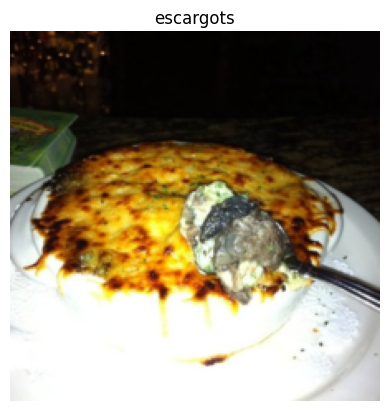

In [20]:
# first, let's see one random image
import random

# Get random idx
random.seed(42)
random_idx = random.randint(0, len(small_train_dataset))

# Get random image and label
img, label = small_train_dataset[random_idx]

# matplotlib expects image to be as numpy array. Also matplot lib expect color channels to be last
# torch format [C, H, W] -> numpy format [H, W, C]
img_to_np = img.permute(1, 2, 0).cpu().numpy()

plt.imshow(img_to_np)
plt.title(small_train_dataset.classes[label])
plt.axis(False)

print(f"\nImage shape: {img.shape} | numpy shape: {img_to_np.shape}")
print(f"Image data type: {img.dtype}\n\n")

In [21]:
# Now create function to plot random images

def plot_random_images(dataset, seed=None):
    if seed:
        torch.manual_seed(seed)

    fig = plt.figure(figsize=(12,12))
    rows, cols = 4, 4

    for i in range(1, rows*cols+1):
        
        # Get random index, same as we did with random module, but using pytorch.
        random_idx = torch.randint(1, len(dataset), size=(1,)).item() 
        

        img, label = dataset[random_idx]
        img_to_np = img.permute(1, 2, 0).cpu().numpy()

        fig.add_subplot(rows, cols, i)
        
        plt.imshow(img_to_np)
        plt.title(dataset.classes[label])
        plt.axis(False)

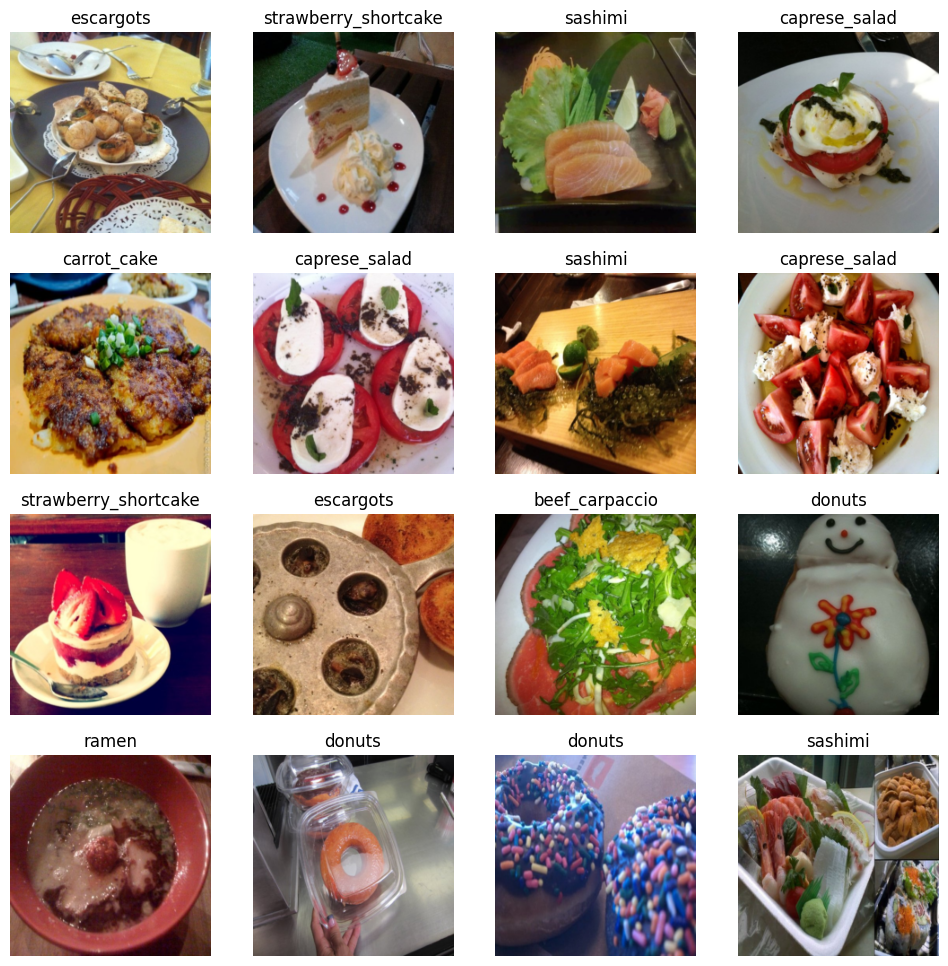

In [22]:
plot_random_images(dataset=small_train_dataset, seed=42)

NOTE: If we plot more and more random images, we could see that Food101 Dataset has quite big issue. Some of the images are in the wrong class

It's known as *noise* in datasets.

### Creating DataLoaders

In [23]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() # Use all of CPU cores, in my case it will be 16

train_dataloader = DataLoader(
    dataset=small_train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    pin_memory=True # Reserve memory for GPU data operations. Works only with GPU and loads DataLoader faster
)

test_dataloader = DataLoader(
    dataset=small_test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x740ad8c19e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7408c46d7110>)

In [24]:
# Let's see one batch from dataloader
img, label = next(iter(train_dataloader))
img.shape, label

(torch.Size([32, 3, 224, 224]),
 tensor([6, 3, 8, 7, 8, 4, 5, 6, 1, 2, 3, 1, 8, 2, 2, 8, 8, 7, 0, 1, 7, 5, 5, 5,
         9, 7, 1, 1, 9, 6, 8, 8]))

## Building functions to train our model.

In this section we're going to build 3 main functions:

1. `train_step()` - a step to train model 1 time. Function will return a dict with average loss and accuracy.
2. `test_step()` - a step to test our model 1 time. Function will return a dict with average test loss and accuracy.
3. `model_train()` - a loop to train our model n times of epochs. Returns training time and dict with all metrics from `train_step()` and `test_step()`
4. `plot_curves()` - plot our losses and accuracies. Compare them.

Parameters we use:

* scaler - changes some data type from float32 to float16, optimizing and speeding model performance. Almost doesn't affect data
* scheduler - dynamically changes lr every epoch. There are different types of scheduler and some of them require different implementation.

In [18]:
from typing import Literal
import torchmetrics

def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    accuracy_fn: torchmetrics.metric.Metric,
    scaler: torch.amp.GradScaler,
    device: Literal['cuda', 'cpu']
):
    # Put model in the training mode
    model.train()

    # Set loss and accuracy values to 0
    train_loss, train_acc = 0, 0 

    # Start a loop on batches
    for X, y in dataloader:

        # Put our data on target device and let 'pin_memory' from DataLoader work properly. To do so, enable 'non_blocking'
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # autocast will allow to use scaler.
        with torch.amp.autocast("cuda"):

            # Make the forward pass
            y_logits = model(X)
            loss = loss_fn(y_logits, y)

        # Loss backward, but with scaler
        scaler.scale(loss).backward()

        # Optimizer step, with scaler
        scaler.step(optimizer)

        # Update the scaler
        scaler.update()

        # Update out loss
        train_loss += loss.item()

        # To calculate the accuracy we have to change raw model's outputs into prediction probabilities
        y_pred = y_logits.argmax(dim=1)

        acc = accuracy_fn(y_pred, y)
        train_acc += acc.item()
        
    # Calculate average train and test losses
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return {
        "model_name": model.__class__.__name__,
        "train_loss": train_loss,
        "train_acc": train_acc
    } 

In [19]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn: torchmetrics.metric.Metric,
    device: Literal['cuda', 'cpu']
):
    # Set test loss and accuracy to 0
    test_loss, test_acc = 0, 0

    # Put model into evaluating mode
    model.eval()
    with torch.inference_mode():

        # Start the evaluation loop on batches
        for X, y in dataloader:

            # Put our data on the target device and enable 'pin_memory' feature from DataLoader
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
    
            # Do the forward pass
            y_logits = model(X)
    
            # Calculate the loss
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
    
            # Calculate accuracy, changing raw logits to pred probs
            y_pred = y_logits.argmax(dim=1)
            acc = accuracy_fn(y_pred, y)
            test_acc += acc.item()

    # Calculate average loss and accuracy
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return {
        "model_name": model.__class__.__name__,
        "test_loss": test_loss,
        "test_acc": test_acc
    }

In [20]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def model_train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    accuracy_fn: torchmetrics.metric.Metric,
    scaler: torch.amp.GradScaler,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    device: Literal['cuda', 'cpu'],
    model_name: str,
    epochs: int=5
):
    # Create a dictionary with all results
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "model_name": model_name
    }

    # Start the timer
    start_timer = timer()

    # Create a training loop
    for epoch in tqdm(range(epochs), desc="Training epochs"):
        print(f"\n================ Epochs: {epoch+1} ================")

        # Call train step save train_loss, train_acc to train_metrics
        train_metrics = train_step(
            model=model,
            dataloader=train_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            scaler=scaler,
            device=device
        )

        # Call test step and save test_loss, test_acc to test_metrics
        test_metrics = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device
        )

        # Update learning rate
        scheduler.step()

        # Parse metrics
        train_loss = train_metrics["train_loss"]
        train_acc = train_metrics["train_acc"]
        test_loss = test_metrics["test_loss"]
        test_acc = test_metrics["test_acc"]

        # Update our model results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Reset accuracy function
        accuracy_fn.reset()

        # Print out more information on each epoch
        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f} % | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f} %\n")

    # Calculate total training time
    end_timer = timer()
    total_training_time = end_timer - start_timer
    model_name = model.__class__.__name__

    # Print training time and model name
    print(f"\n\nTotal training time on {device} is {total_training_time:.3f} seconds")
    print(f"Model name: {model_name}")

    # Return tuple
    return total_training_time, results

In [21]:
def plot_curves(results: dict[str, list[float]]):

    # Get our metrics from results
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]

    test_loss = results["test_loss"]
    test_acc = results["test_acc"]

    epochs = range(len(train_loss))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    plt.plot(epochs, test_acc, label="Test acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

## Build first model architecture

As I mentioned in the very beggining, I want to see how simple CNN would work on such dataset as Food101

Let's build a model with 4 blocks and a classifier layer.

For this section we also define accuracy function, loss, optimzer etc.

In [22]:
class FoodClassificationModel0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            # All filter size are default values for Image classification (kernel_size=3, padding=1, stride=1)
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),

            # Normalizing layer
            nn.BatchNorm2d(num_features=hidden_units),
            nn.ReLU(),

            # Increase amount of features to let our model learn more
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=hidden_units*2),
            nn.ReLU(),

            # Resize image
            nn.MaxPool2d(2) # [224, 224] -> ~ [112, 112]. We lose couple of pixels on each Conv2D
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=hidden_units*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=hidden_units*8),
            nn.ReLU(),
            nn.MaxPool2d(2) # ~~ [112, 112] -> [56, 56]
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*8, out_channels=hidden_units*8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=hidden_units*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*8, out_channels=hidden_units*16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=hidden_units*16),
            nn.ReLU(),
            nn.MaxPool2d(2) # ~~ [56, 56] -> [28, 28]
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*16, out_channels=hidden_units*16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=hidden_units*16),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1, 1)) # changes our batch from [32, 3, H, W] -> [32, 3, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16, out_features=hidden_units*8),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*8, out_features=256),
            nn.ReLU(),

            # Add small dropout
            nn.Dropout(0.1),
            nn.Linear(in_features=256, out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block4(self.conv_block3(self.conv_block2(self.conv_block1(x)))))

How much parameters does our model has? Let's find out

Formula to calculate parameter on a layer is out_features * in_features + out_features

If it's a feature layer, then: out_features * in_features * H * W + out_features;

If it's BatchNormalization layer, then: num_features * 2

Let's calculate, pretending we have 32 hidden units

1. self.conv_block1:

   * 32 * 3 * 3 * 3 + 32 -> 896
   * 32 * 2 -> 64
   * 64 * 32 * 3 * 3 + 64 -> 18,496
   * 64 * 2 -> 128
2. self.conv_block2:

    * 128 * 64 * 3 * 3 + 128 -> 73,856
    * 128 * 2 -> 256
    * 256 * 128 * 3 * 3 + 256 -> 295,168
    * 256 * 2 = 512
3. self.conv_block3:

    * 256 * 256 * 3 * 3 + 256 -> 590,080
    * 256 * 2 -> 512
    * 512 * 256 * 3 * 3 + 512 -> 1,180,160
    * 512 * 2 -> 1024
4. self.conv_block4:

    * 512 * 512 * 3 * 3 + 512 -> 2,359,808
    * 512 * 2 -> 1024
5. self.classifier:

    * 256 * 512 + 256 -> 131,328
    * 256 * 256 + 256 -> 65,792
    * 10 * 256 + 10 -> 2,570


Total amount of parameters:
896 + 64 + 18,496 + 128 + 73,856 + 256 + 295,168 + 512 + 590,080 + 512 + 1,180,160 + 1024 + 2,359,808 + 1024 + 131,328 + 65,792 + 2,570 = 4,721,674

in bytes it's number multiplied by 4 (each parameter is float32 -> float32 is 4 bytes)
In MB it's ~ 18 MB (4,721,674 * 4 / 1024 / 1024)

### Initializing our model

In [30]:
import gc

# Jupyter Lab keeps parameters and some data in RAM and VRAM, even when cell is not running.
# To prevent copying models, we will delete it from memory every time before initializing.

if "model_0" in globals(): # check if model_0 already exists
    del model_0 # if so, delete it
    
torch.cuda.empty_cache() # Delete cache in GPU
gc.collect() # Clean our memory



# input shape = number of color channels
# hidden units = hyperparameter
# output shape = number of classes, in our case 10
model_0 = FoodClassificationModel0(input_shape=3, hidden_units=32, output_shape=len(small_train_dataset.classes)).to(device)
model_0

FoodClassificationModel0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3):

In [31]:
# Setup how much epochs we want to train our model
EPOCHS = 25

### Setting up the model

In [32]:
import gc

if "optimizer" in globals():
    del optimizer
if "scheduler" in globals():
    del scheduler
if "accuracy_fn" in globals():
    del accuracy_fn

torch.cuda.empty_cache()
gc.collect()

# CrossEntropyLoss is default for MultiClass Classification problems
loss_fn = nn.CrossEntropyLoss()

# Adam is optimal solution for now, learning rate is also default 0.001
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=1e-3)

# Scheduler will dynamically change learning rate during each epoch
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer, # optimizer, which learning rate we will change
    T_max=EPOCHS, # Maximum steps to make, until we reach final learning rate value. Same as epochs, so we will have a smooth curve
    eta_min=1e-7 # Most minumal learning rate we can reach
)

# Scaler, changes some float32 to float16 during computation
scaler = torch.amp.GradScaler("cuda")

# Accuracy function from torchmetrics
accuracy_fn = torchmetrics.classification.MulticlassAccuracy(average="micro").to(device)

### Train our model and plot results

NOTE: we do not use any data augmentation yet

In [33]:
model_0_results = model_train(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler=scaler,
    device=device,
    model_name="Model 0",
    epochs=EPOCHS
)

Training epochs:   0%|          | 0/25 [00:00<?, ?it/s]


================ Epochs: 1 ================
Train loss: 2.0480, Train acc: 0.23 % | Test loss: 1.9120, Test acc: 0.29 %


================ Epochs: 2 ================
Train loss: 1.8518, Train acc: 0.30 % | Test loss: 1.8784, Test acc: 0.34 %


================ Epochs: 3 ================
Train loss: 1.7364, Train acc: 0.36 % | Test loss: 1.6230, Test acc: 0.41 %


================ Epochs: 4 ================
Train loss: 1.6206, Train acc: 0.41 % | Test loss: 1.6587, Test acc: 0.42 %


================ Epochs: 5 ================
Train loss: 1.5299, Train acc: 0.44 % | Test loss: 1.3771, Test acc: 0.51 %


================ Epochs: 6 ================
Train loss: 1.4579, Train acc: 0.46 % | Test loss: 1.3450, Test acc: 0.51 %


================ Epochs: 7 ================
Train loss: 1.4092, Train acc: 0.49 % | Test loss: 1.9412, Test acc: 0.31 %


================ Epochs: 8 ================
Train loss: 1.3346, Train acc: 0.52 % | Test loss: 1.1936, Test acc: 0.57 %


================ Epochs

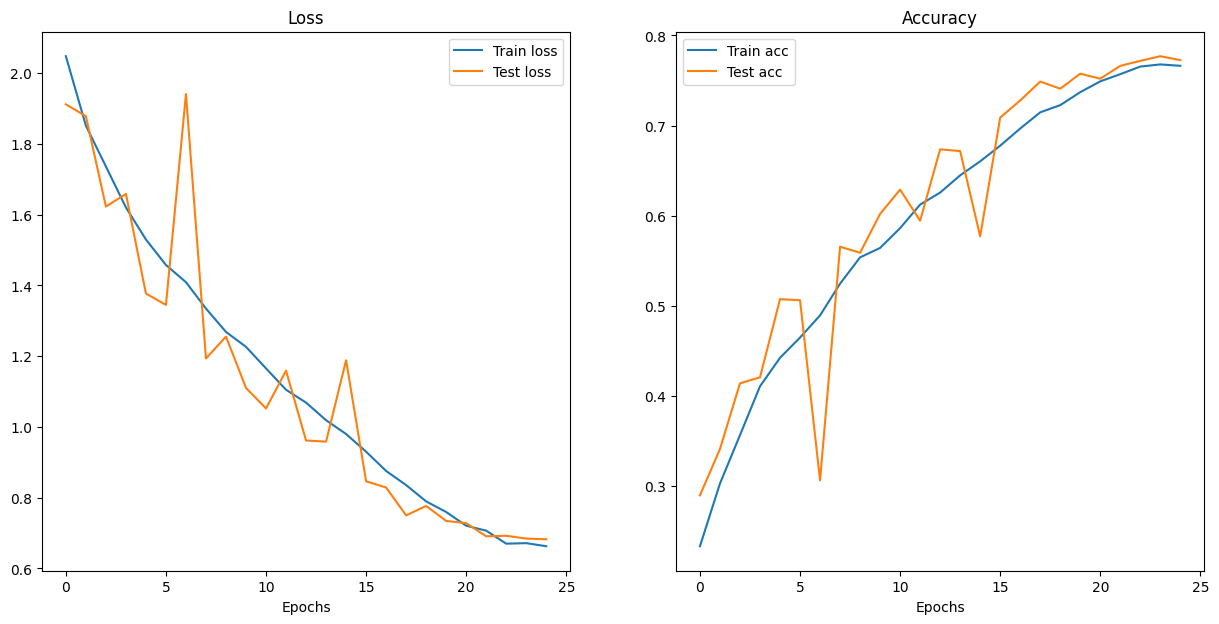

In [34]:
plot_curves(results=model_0_results[1])

In [35]:
model_0_results[1]

{'train_loss': [2.048043953104222,
  1.8517739067686365,
  1.736383944369377,
  1.6205548113964974,
  1.5298804511415198,
  1.4578558150758134,
  1.409226570484486,
  1.3346289299904033,
  1.2686051120149329,
  1.2263437600845986,
  1.1654143275098598,
  1.1050886050183721,
  1.0687274131369084,
  1.0189354992927389,
  0.9799733925372996,
  0.9299559818937423,
  0.8755217552185058,
  0.8355271443407586,
  0.7894561330054669,
  0.7594448234172577,
  0.7206969913015975,
  0.7066983865930679,
  0.6699367317747562,
  0.6714093368104164,
  0.662721956537125],
 'train_acc': [0.2335549645601435,
  0.30310283683715983,
  0.3566932624324839,
  0.4109042553191489,
  0.4424645390916378,
  0.46493794322013854,
  0.48949468085106385,
  0.5246897163543295,
  0.5538563829787234,
  0.5643173758019793,
  0.5862588651636813,
  0.6123670212765957,
  0.6257092199427017,
  0.644813829787234,
  0.6603280140998515,
  0.6777039007937654,
  0.6967198582405739,
  0.7146719859001485,
  0.7226507093044038,
  0.73

### Making Matrix Confusion Plot

* To do so, firstly we will use already trained model on test_dataloader to get y_pred probs.
* Using `torchmetrics.ConfusionMatrix` setup instance of ConfusionMatrix class and then compare y_pred probs with actual labels.
* Build plot function to visualize confusion matrix.

In [36]:
from tqdm.auto import tqdm

# 1. Making predictions with trained model
y_preds = []

model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        
    # Put data on the target device
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
    
        # Get raw logits model's output
        y_logits = model_0(X)
    
        # Turn logits into prediction probabilities
        y_pred = torch.softmax(y_logits.squeeze(), dim=1).argmax(dim=1)

        # Change y_pred to cpu for future plot
        y_preds.append(y_pred.cpu())

y_preds_tensor = torch.cat(y_preds)
len(y_preds), len(y_preds_tensor), y_preds_tensor[:10]

Making predictions...:   0%|          | 0/79 [00:00<?, ?it/s]

(79, 2500, tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [37]:
from torchmetrics import ConfusionMatrix

# Get metrics using torchmetrics
confmat = ConfusionMatrix(task="multiclass", num_classes=len(small_train_dataset.classes))

confmat_tensor_model_0 = confmat(preds=y_preds_tensor, target=torch.tensor(small_test_dataset.targets))

In [38]:
confmat_tensor_model_0

tensor([[204,   1,   3,   1,  28,   3,   3,   0,   1,   6],
        [  5, 182,   0,   7,  11,  10,   8,  24,   1,   2],
        [  3,   0, 205,   8,   2,   1,   2,   3,  23,   3],
        [  2,   1,   7, 209,   0,   7,   1,  16,   5,   2],
        [ 25,  10,   1,   0, 193,   2,   9,   3,   6,   1],
        [  9,  11,   3,  10,   8, 176,   0,  22,   4,   7],
        [ 19,   7,   2,   6,   7,   2, 190,   7,   9,   1],
        [  2,  15,   4,  31,   2,  24,   4, 163,   4,   1],
        [  2,   0,  31,   3,   4,   0,   5,   5, 187,  13],
        [  5,   0,   1,  10,   1,   3,   0,   0,  14, 216]])

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, normalize=False, figsize=(9, 9)):

    if hasattr(cm, "cpu"):
        cm = cm.cpu().numpy()

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, cmap="Blues")

    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        xlabel="Predicted label",
        ylabel="True label",
        title="Confusion Matrix",
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    fig.tight_layout()
    plt.show()

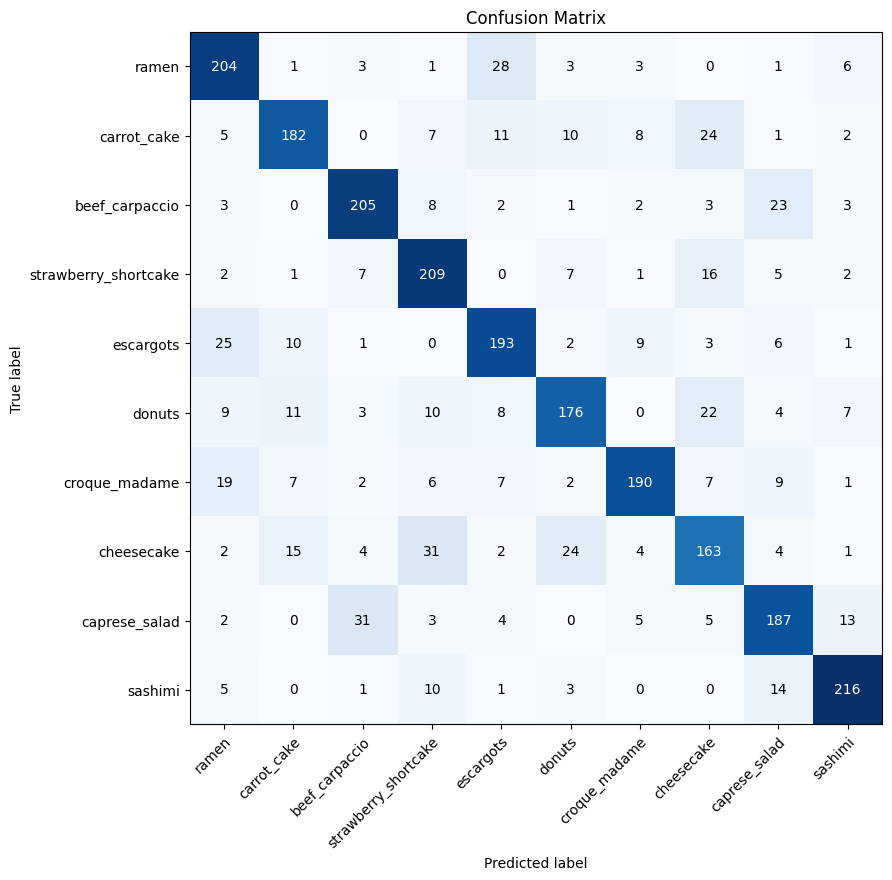

In [40]:
plot_confusion_matrix(confmat_tensor_model_0, small_test_dataset.classes)

### Evaluating our model 

In [41]:
def eval_model(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn: torchmetrics.metric.Metric,
    model_name: str,
    device: Literal['cuda', 'cpu']
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Evaluating model..."):
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

            y_logits = model(X)

            loss += loss_fn(y_logits, y)
            
            y_pred = y_logits.argmax(dim=1)
            acc += accuracy_fn(y_pred, y)

        loss /= len(dataloader)
        acc /= len(dataloader)
        
    accuracy_fn.reset()
    return {
        "model_name": model_name,
        "loss": loss.item(),
        "acc": acc.item()
    }     

In [42]:
model_0_eval_results = eval_model(
    model=model_0,
    dataloader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn, 
    device=device,
    model_name="model 0"
)

model_0_eval_results

Evaluating model...:   0%|          | 0/79 [00:00<?, ?it/s]

{'model_name': 'model 0',
 'loss': 0.6823145151138306,
 'acc': 0.7725474834442139}

## Experimenting with data augmentation.

Judging on our Evaluation metrics, Confusion Matrix, our model is doing quite good on 25-50 epochs.

There are couple of things we could try to do, for example changing optimizer, trying to add one more conv_block layer (to increase number of learning features). I propose to run the same model architecture, but this time using some Data Augmentation.

* Initialize a new model from `FoodClassificationModelV0` class
* Create train/test transforms
* Create new Datasets & DataLoaders
* Set up model configs (optimizer, loss, etc...)
* If results are better -> play with different optimizers

In [43]:
import gc

if "model_0" in globals():
    del model_0

if "model_0_tr" in globals():
    del model_0_tr

torch.cuda.empty_cache()
gc.collect()

model_0_tr = FoodClassificationModel0(input_shape=3, hidden_units=32, output_shape=len(small_train_dataset.classes)).to(device)
model_0_tr

FoodClassificationModel0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3):

### Creating transforms

Although our model does not overfit, adding some light data augmentation could be useful.
We also add Normalization transform, with reccomended parameters from `ImageNet`

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

In [44]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomPerspective(p=0.5)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

### Creating Datasets & DataLoaders

In [45]:
small_train_dataset_tr = CustomImageFolder(
    subset=train_subset,
    original_dataset=train_dataset,
    transform=train_transform,
    class_map=class_map,
    target_transform=None
)

small_test_dataset_tr = CustomImageFolder(
    subset=test_subset,
    original_dataset=test_dataset,
    transform=test_transform,
    target_transform=None,
    class_map=class_map
)

small_train_dataset_tr, small_test_dataset_tr

(<__main__.CustomImageFolder at 0x7408c4591a90>,
 <__main__.CustomImageFolder at 0x7408c81483e0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1345534].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9656862..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.64].
Clippi

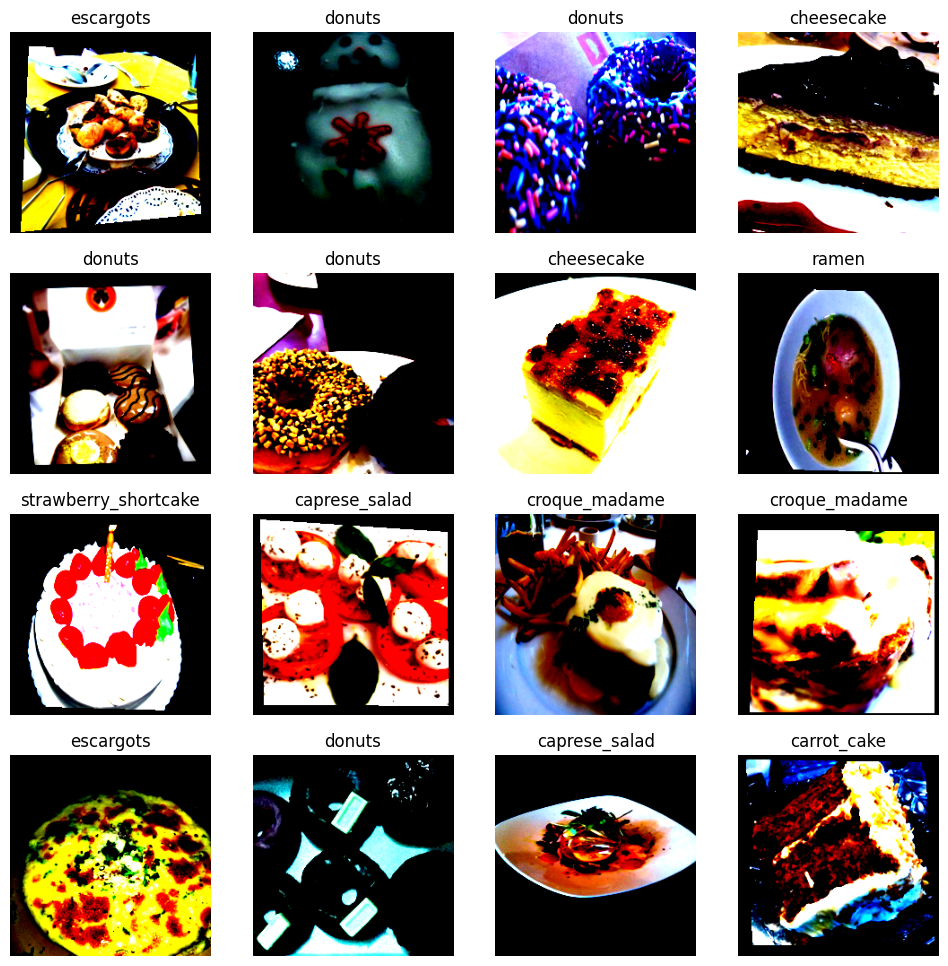

In [46]:
# Lets visualize some images from transformed dataset
# We can ignore the warning from below, it does not affect our code

plot_random_images(dataset=small_train_dataset_tr, seed=42)

In [47]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=small_train_dataset_tr,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=small_test_dataset_tr,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x740c3f16fed0>,
 <torch.utils.data.dataloader.DataLoader at 0x7408c81488a0>)

### Configure the model

In [48]:
EPOCHS = 25

In [49]:
import gc
from torchmetrics.classification import MulticlassAccuracy

if "optimizer" in globals():
    del optimizer
if "scheduler" in globals():
    del scheduler
if "scaler" in globals():
    del scaler
if "accuracy_fn" in globals():
    del accuracy_fn

torch.cuda.empty_cache()
gc.collect()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0_tr.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=EPOCHS,
    eta_min=1e-7
)

scaler = torch.amp.GradScaler("cuda")

accuracy_fn = MulticlassAccuracy(average='micro').to(device)


### Run our new model

In [50]:
model_0_tr_results = model_train(
    model=model_0_tr,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    scheduler=scheduler,
    scaler=scaler,
    device=device,
    model_name="model 0 with data augm",
    epochs=EPOCHS
)

Training epochs:   0%|          | 0/25 [00:00<?, ?it/s]


================ Epochs: 1 ================
Train loss: 2.0963, Train acc: 0.22 % | Test loss: 1.8738, Test acc: 0.31 %


================ Epochs: 2 ================
Train loss: 1.8961, Train acc: 0.29 % | Test loss: 1.9228, Test acc: 0.26 %


================ Epochs: 3 ================
Train loss: 1.7727, Train acc: 0.33 % | Test loss: 1.6071, Test acc: 0.40 %


================ Epochs: 4 ================
Train loss: 1.7002, Train acc: 0.36 % | Test loss: 1.7134, Test acc: 0.39 %


================ Epochs: 5 ================
Train loss: 1.6174, Train acc: 0.40 % | Test loss: 1.4734, Test acc: 0.46 %


================ Epochs: 6 ================
Train loss: 1.5261, Train acc: 0.45 % | Test loss: 1.7140, Test acc: 0.41 %


================ Epochs: 7 ================
Train loss: 1.4624, Train acc: 0.47 % | Test loss: 1.5985, Test acc: 0.44 %


================ Epochs: 8 ================
Train loss: 1.4111, Train acc: 0.49 % | Test loss: 1.3139, Test acc: 0.53 %


================ Epochs

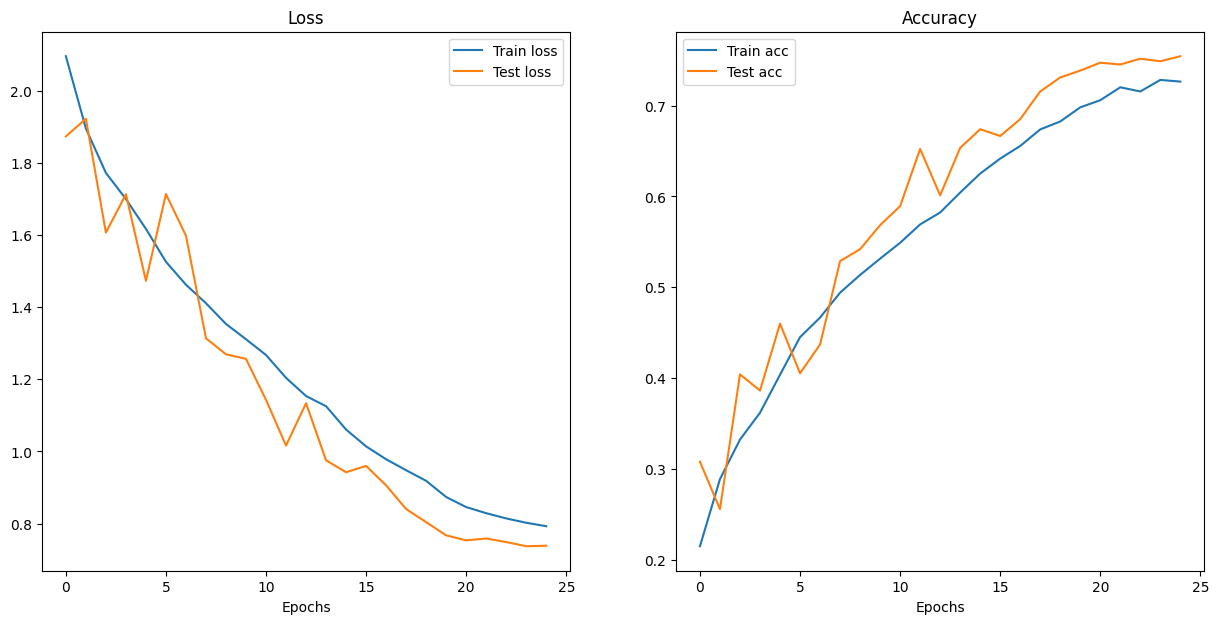

In [51]:
plot_curves(results=model_0_tr_results[1])

In [52]:
y_preds = []

model_0_tr.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        y_logits = model_0_tr(X)

        y_pred = torch.softmax(y_logits.squeeze(), dim=1).argmax(dim=1)

        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:5]

Making predictions...:   0%|          | 0/79 [00:00<?, ?it/s]

tensor([6, 2, 2, 8, 2])

In [53]:
# Let's plot confusion matrix
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(small_train_dataset.classes))

confmat_tensor = confmat(preds=y_pred_tensor, target=torch.tensor(small_test_dataset.targets))
confmat_tensor

tensor([[209,   2,   2,   1,  22,   3,   3,   0,   1,   7],
        [  4, 177,   2,   4,  13,  22,   8,  15,   2,   3],
        [  3,   2, 207,   4,   4,   1,   3,   2,  20,   4],
        [  1,   1,   8, 208,   0,   9,   1,  12,   5,   5],
        [ 28,  11,   0,   0, 183,   3,  10,   1,  12,   2],
        [  3,   8,   2,   9,   9, 183,   4,  18,   4,  10],
        [ 19,   7,   1,   4,   9,   2, 186,   8,  12,   2],
        [  0,  12,   4,  42,   3,  25,   6, 149,   9,   0],
        [  1,   0,  31,   5,   5,   0,   6,   1, 173,  28],
        [  2,   0,   2,   7,   0,   4,   1,   1,  15, 218]])

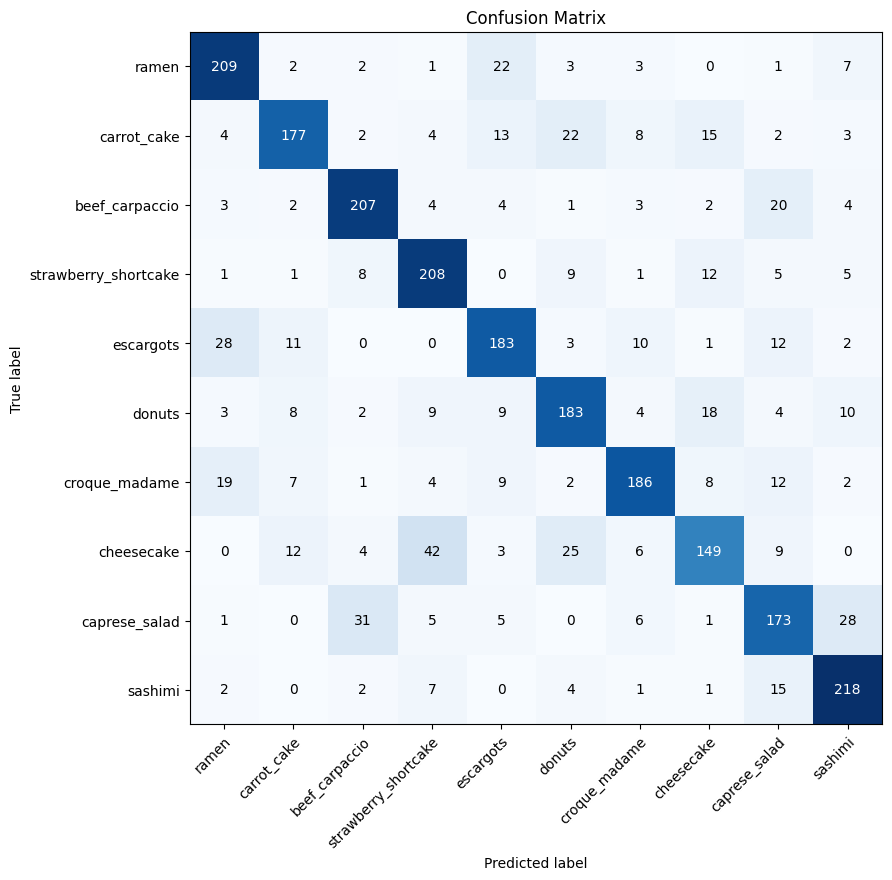

In [54]:
plot_confusion_matrix(confmat_tensor, small_test_dataset.classes)

### Evaluate model

In [55]:
model_0_tr_eval_results = eval_model(
    model=model_0_tr,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
    model_name="Model 0 transformed"
)

Evaluating model...:   0%|          | 0/79 [00:00<?, ?it/s]

### Compare two models

In [56]:
from typing import List

def compare_models(results: List[dict[str, float]]):
    
    epochs = range(len(results[0]["train_loss"]))
    plt.figure(figsize=(15, 7))
    
    for i, result in enumerate(results):
        model_name = result["model_name"]
        
        train_loss = result["train_loss"]
        train_acc = result["train_acc"]

        test_loss = result["test_loss"]
        test_acc = result["test_acc"]

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label=f"Train loss for {model_name}")
        plt.plot(epochs, test_loss, label=f"Test loss for {model_name}")
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.legend()
    
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label=f"Train acc for model {model_name}")
        plt.plot(epochs, test_acc, label=f"Test acc for model: {model_name}")
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.legend()
        

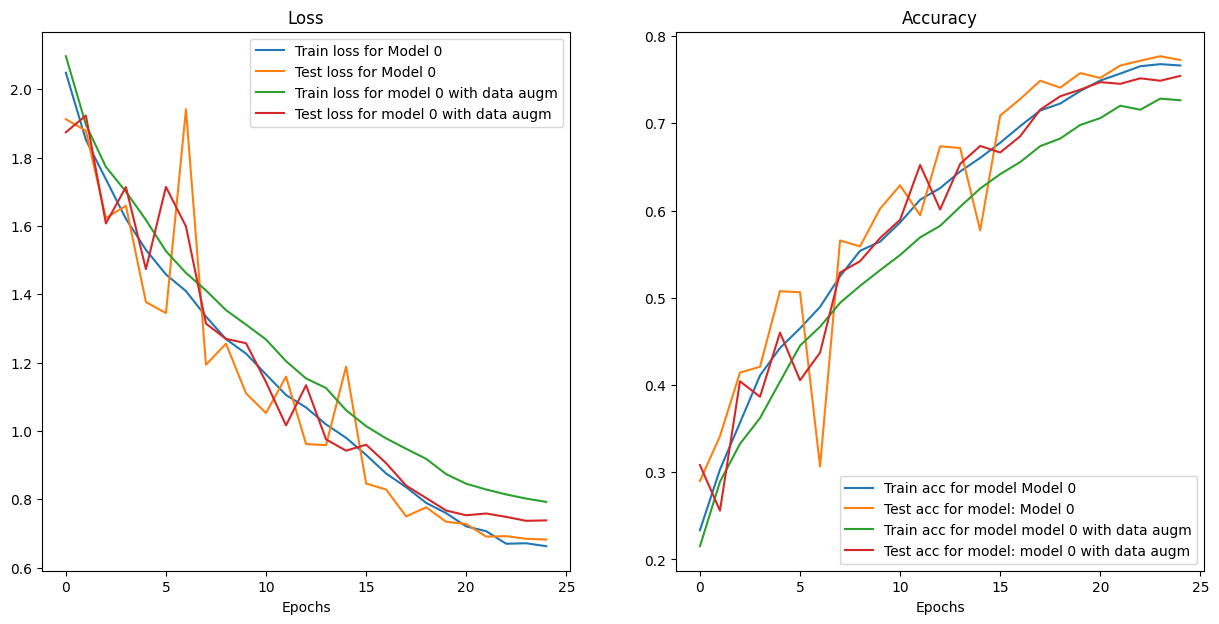

In [57]:
results = [model_0_results[1], model_0_tr_results[1]]

compare_models(results)

We can see that data augmentation not really helps. Moreover using data augmentation makes model worse. 

In general, we could experiment even more, playing with amount of conv_blocks, using more precise tranforms and a lot of more, but it is unnecessary.

This notebook is my showcase, a small sum up of what I already learnt about CNNs.

So let's make one lest experiment, using different optimizer and then train our best model on whole 101 class.

## Final experiment, using AdamW

I will skip writing comments on what I do, because the code is going to be the same

In [58]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=small_train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=small_test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x740ad66bf820>,
 <torch.utils.data.dataloader.DataLoader at 0x740ae2c7bbf0>)

In [59]:
import gc

if "model_0_tr" in globals():
    del model_0_tr
if "model_0_opt" in globals():
    del model_0_opt
    
torch.cuda.empty_cache()
gc.collect()

model_0_opt = FoodClassificationModel0(input_shape=3, hidden_units=32, output_shape=len(small_train_dataset.classes)).to(device)
model_0_opt

FoodClassificationModel0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3):

In [60]:
EPOCHS = 25

In [61]:
import gc
from torchmetrics.classification import MulticlassAccuracy

if "optimizer" in globals():
    del optimizer
if "scheduler" in globals():
    del scheduler
if "accuracy_fn" in globals():
    del accuracy_fn
if "scaler" in globals():
    del scaler

torch.cuda.empty_cache()
gc.collect()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(params=model_0_opt.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=EPOCHS,
    eta_min=1e-7
)

scaler = torch.amp.GradScaler("cuda")

accuracy_fn = MulticlassAccuracy(average="micro").to(device)

In [62]:
model_0_opt_results = model_train(
    model=model_0_opt,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    accuracy_fn=accuracy_fn,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler=scaler,
    device=device,
    model_name="Model with AdamW",
    epochs=EPOCHS
)

Training epochs:   0%|          | 0/25 [00:00<?, ?it/s]


================ Epochs: 1 ================
Train loss: 2.0705, Train acc: 0.23 % | Test loss: 1.9485, Test acc: 0.29 %


================ Epochs: 2 ================
Train loss: 1.8788, Train acc: 0.30 % | Test loss: 1.8966, Test acc: 0.28 %


================ Epochs: 3 ================
Train loss: 1.7566, Train acc: 0.36 % | Test loss: 1.7097, Test acc: 0.36 %


================ Epochs: 4 ================
Train loss: 1.6661, Train acc: 0.39 % | Test loss: 1.7351, Test acc: 0.37 %


================ Epochs: 5 ================
Train loss: 1.5871, Train acc: 0.41 % | Test loss: 1.5946, Test acc: 0.41 %


================ Epochs: 6 ================
Train loss: 1.4971, Train acc: 0.46 % | Test loss: 1.4596, Test acc: 0.47 %


================ Epochs: 7 ================
Train loss: 1.4343, Train acc: 0.48 % | Test loss: 1.3891, Test acc: 0.49 %


================ Epochs: 8 ================
Train loss: 1.3789, Train acc: 0.50 % | Test loss: 1.3340, Test acc: 0.50 %


================ Epochs

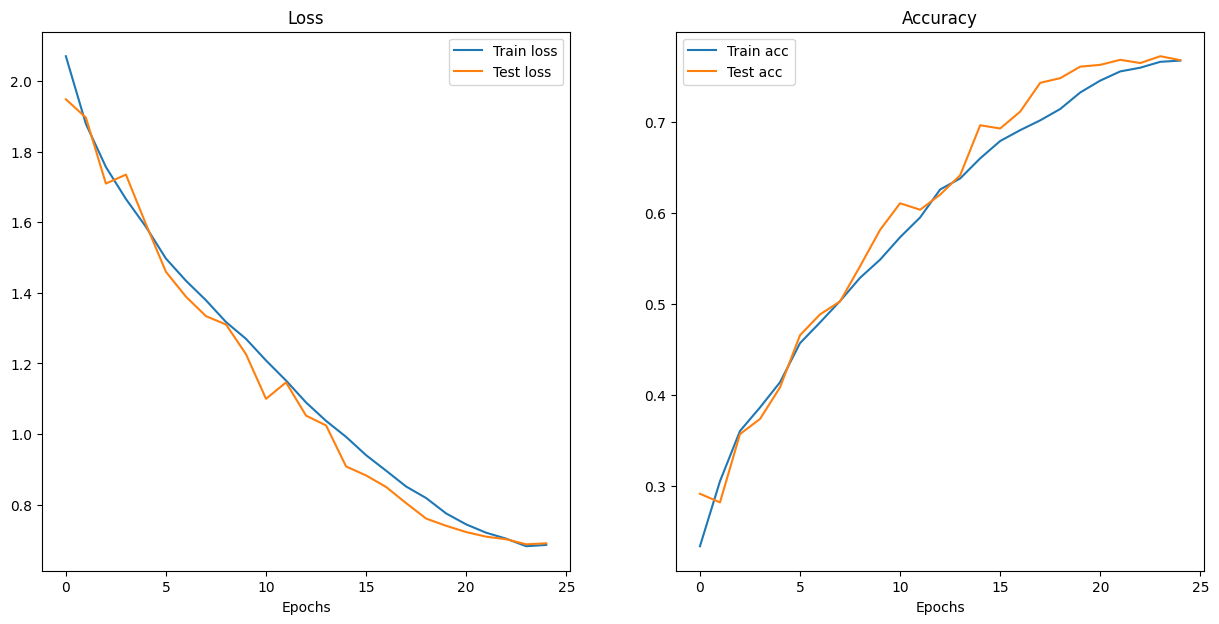

In [63]:
plot_curves(model_0_opt_results[1])

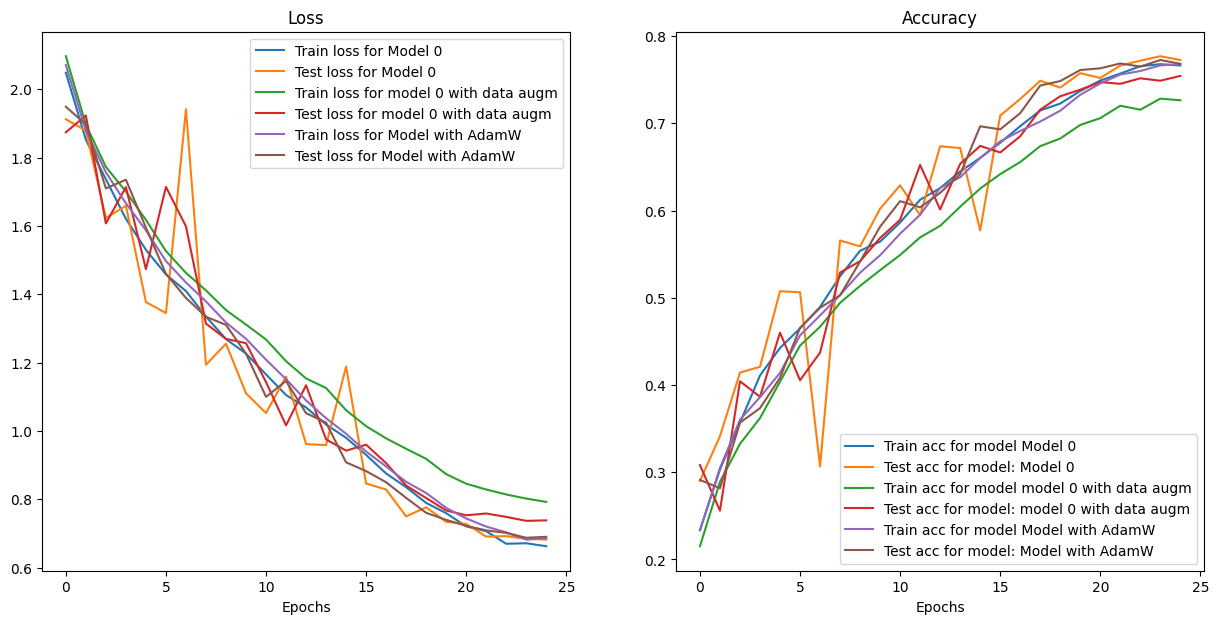

In [64]:
results = [model_0_results[1], model_0_tr_results[1], model_0_opt_results[1]]

compare_models(results=results)

In [65]:
model_0_opt_eval_results = eval_model(
    model=model_0_opt,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
    model_name="Model 0, AdamW"
)

model_0_opt_eval_results

Evaluating model...:   0%|          | 0/79 [00:00<?, ?it/s]

{'model_name': 'Model 0, AdamW',
 'loss': 0.6902092695236206,
 'acc': 0.7681962251663208}

## Compare all models

In [66]:
import pandas as pd

compare_eval_results = pd.DataFrame([model_0_eval_results, model_0_tr_eval_results, model_0_opt_eval_results])
compare_eval_results

model_name      loss       acc
0              model 0  0.682315  0.772547
1  Model 0 transformed  0.738363  0.754351
2       Model 0, AdamW  0.690209  0.768196

In [67]:
model_0_results[0]

661.6096089869989

In [68]:
# Add training time 
compare_eval_results["training_time"] = [model_0_results[0], model_0_tr_results[0], model_0_opt_results[0]]
compare_eval_results

model_name      loss       acc  training_time
0              model 0  0.682315  0.772547     661.609609
1  Model 0 transformed  0.738363  0.754351     665.213790
2       Model 0, AdamW  0.690209  0.768196     664.467535

Text(0, 0.5, 'model')

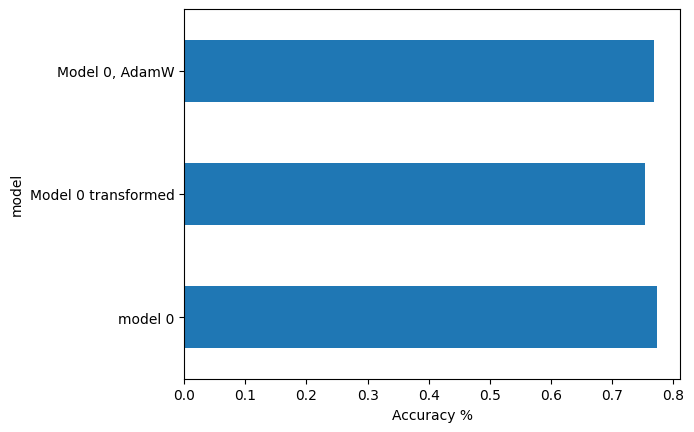

In [69]:
# Visualize results on 3 models
compare_eval_results.set_index("model_name")["acc"].plot(kind="barh")
plt.xlabel("Accuracy %")
plt.ylabel("model")

## Experimenting with 101 class

Based on all model results, `model_0` without any dataaugmentation shows the best results. The simplier the better!

Let's use that model to train 101 class of food

NOTE: even though we have train and test datasets with 101 class, they don't have `ToTensor` and `Resize` transforms, so we create Datasets again

In [24]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import torchmetrics

In [25]:
from torchvision import transforms, datasets

data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 75750
     Root location: data/splitted_data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 25250
     Root location: data/splitted_data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

Len of train dataset: 75750 | Test dataset: 25250
Number of classes: 101
Image shape: torch.Size([3, 224, 224]), Image data type: torch.float32




(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

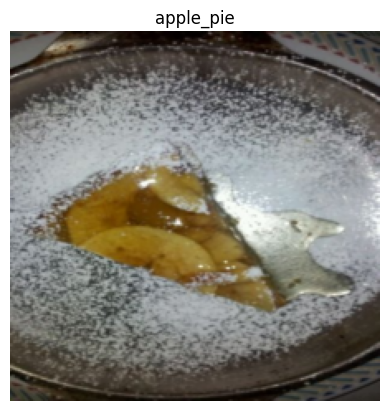

In [26]:
# Print out some data

img, label = train_dataset[0]
print(f"Len of train dataset: {len(train_dataset)} | Test dataset: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Image shape: {img.shape}, Image data type: {img.dtype}\n\n")
plt.imshow(img.permute(1, 2, 0))
plt.title(train_dataset.classes[label])
plt.axis(False)

In [27]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    pin_memory=True
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78e90283bed0>,
 <torch.utils.data.dataloader.DataLoader at 0x78e7cdbaefd0>)

In [28]:
import gc

if "model_0" in globals():
    del model_0
if "model_0_tr" in globals():
    del model_0_tr
if "model_0_opt" in globals():
    del model_0_opt

if "model_0_full" in globals():
    del model_0_full

torch.cuda.empty_cache()
gc.collect()

model_0_full = FoodClassificationModel0(input_shape=3, hidden_units=32, output_shape=len(train_dataset.classes)).to(device)
model_0_full

FoodClassificationModel0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3):

In [29]:
EPOCHS = 25

In [31]:
from torchmetrics.classification import MulticlassAccuracy

import gc

if "loss_fn" in globals():
    del loss_fn
if "optimizer" in globals():
    del optimizer
if "scheduler" in globals():
    del scheduler
if "scaler" in globals():
    del scaler
if "accuracy_fn" in globals():
    del accuracy_fn

torch.cuda.empty_cache()
gc.collect()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0_full.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=EPOCHS,
    eta_min=1e-7
)

scaler = torch.amp.GradScaler("cuda")

accuracy_fn = MulticlassAccuracy(average="micro").to(device)

In [32]:
model_0_full_results = model_train(
    model=model_0_full,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    scheduler=scheduler,
    optimizer=optimizer,
    accuracy_fn=accuracy_fn,
    scaler=scaler,
    device=device,
    model_name="Model 101",
    epochs=EPOCHS
)

Training epochs:   0%|          | 0/25 [00:00<?, ?it/s]


================ Epochs: 1 ================
Train loss: 4.2959, Train acc: 0.04 % | Test loss: 4.0812, Test acc: 0.06 %


================ Epochs: 2 ================
Train loss: 3.8960, Train acc: 0.09 % | Test loss: 3.6877, Test acc: 0.13 %


================ Epochs: 3 ================
Train loss: 3.5965, Train acc: 0.14 % | Test loss: 3.5286, Test acc: 0.16 %


================ Epochs: 4 ================
Train loss: 3.3712, Train acc: 0.18 % | Test loss: 3.1737, Test acc: 0.21 %


================ Epochs: 5 ================
Train loss: 3.1721, Train acc: 0.22 % | Test loss: 3.0018, Test acc: 0.25 %


================ Epochs: 6 ================
Train loss: 2.9940, Train acc: 0.26 % | Test loss: 2.7977, Test acc: 0.29 %


================ Epochs: 7 ================
Train loss: 2.8370, Train acc: 0.29 % | Test loss: 2.6406, Test acc: 0.32 %


================ Epochs: 8 ================
Train loss: 2.6780, Train acc: 0.32 % | Test loss: 2.4707, Test acc: 0.36 %


================ Epochs

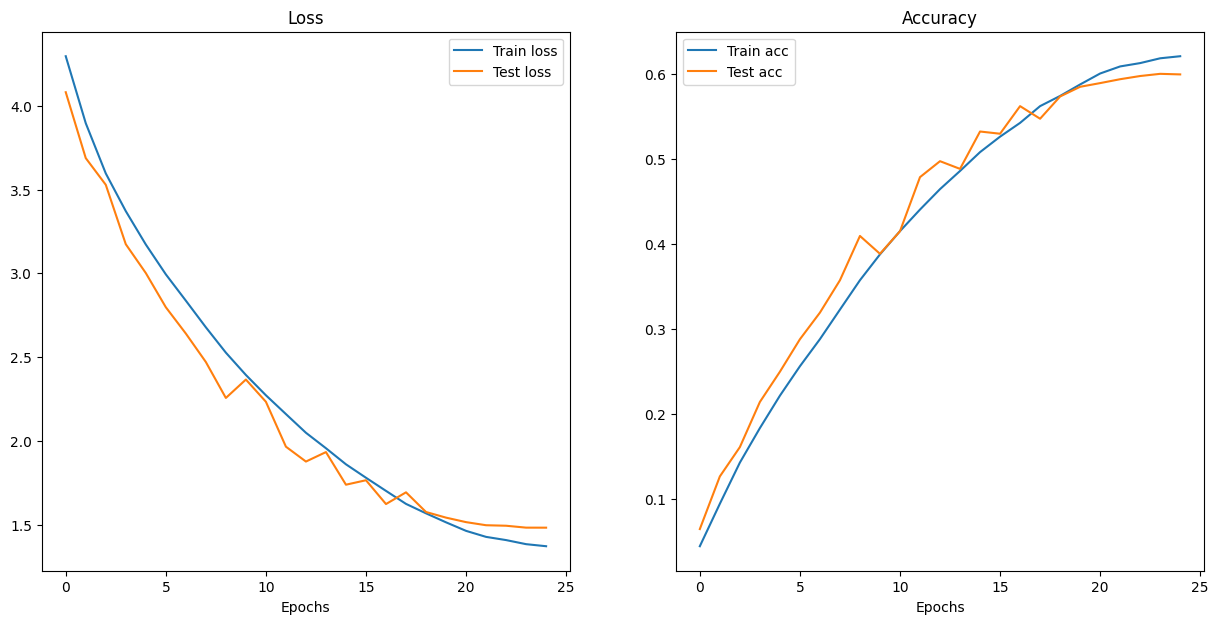

In [33]:
plot_curves(model_0_full_results[1])

## Saving 101 model.

Confusion Matrix on 101 class will not fit the screen, so we skip this step.

At the end we can see that our model architecture is working good on 10 classes but is too simple for 101 class. 

This is very basic CNN architecture and of cource i do not expect it to be good. As I mentioned in the very beggining, this small project is my showcase, experimentation on real data and adjusting CNN.

In [41]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Model_101_class"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print("Saving model...")
torch.save(obj=model_0_full.state_dict(), f=MODEL_SAVE_PATH)

Saving model...
